In [1]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
import torchvision
import torchvision.transforms as T

from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, confusion_matrix

In [2]:
# Download the Oxford IIIT Pet Dataset using the in-built pytorch datasets library

# train_split
raw_train_dataset = torchvision.datasets.OxfordIIITPet(root='./data/oxford-pets', download=True)

# test_split
raw_test_dataset = torchvision.datasets.OxfordIIITPet(root='./data/oxford-pets', split='test', download=True)

print(len(raw_train_dataset))
print(len(raw_test_dataset))

3680
3669


In [3]:
# Helper dataset class to add transformations to the raw data

class preprocessDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, transform):
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        image, target = self.dataset[index]
        augmented_image = self.transform(image)
        return augmented_image, target

In [20]:
'''

# Different preprocessing steps are used for ResNet50 when using pytorch and tensorflow.
# Above preprocessing is equal to the below transformation.

R50_transform_pytorch = T.Compose([
                                    T.Resize(232, interpolation=T.InterpolationMode.BILINEAR),
                                    T.CenterCrop(224),
                                    T.ToTensor(),
                                    T.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225]),
                                  ])

'''

# Pretrained weights that going to load to the model
weights = torchvision.models.resnet.ResNet34_Weights.DEFAULT

# Requiered preprocessing for the R50 model from torchvision
ResNet_preprocess = weights.transforms()



In [21]:
# Preprocessed datasets

train_dataset = preprocessDataset(raw_train_dataset, ResNet_preprocess)
test_dataset = preprocessDataset(raw_test_dataset, ResNet_preprocess)

In [22]:
# Visualize the preprocessed data with raw data

raw_sample = []
train_sample = []

rw = iter(raw_train_dataset)
tr = iter(train_dataset)

for i in range(16):
    raw_sample.append(next(rw)[0])
    train_sample.append(next(tr)[0])

grid1 = torchvision.utils.make_grid([T.Resize((224,224),antialias=True)(T.ToTensor()(i)) for i in raw_sample], nrow=8)
grid2 = torchvision.utils.make_grid([i for i in train_sample], nrow=8)

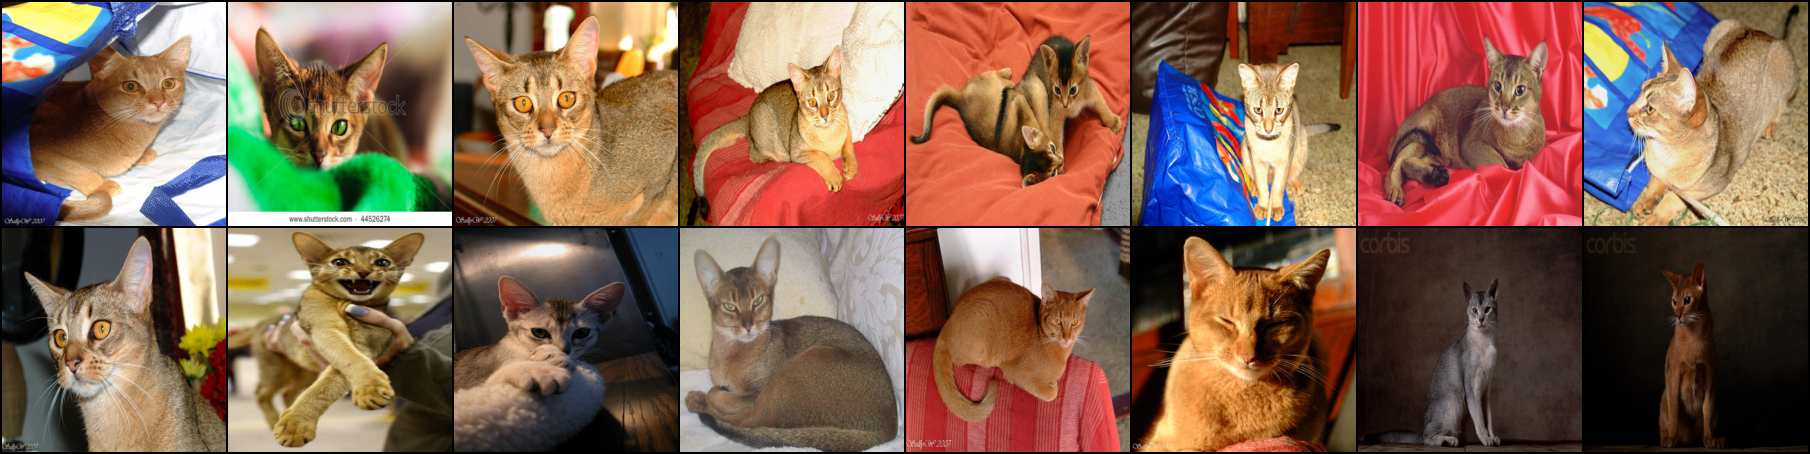

In [23]:
# raw sample preview
T.ToPILImage()(grid1)

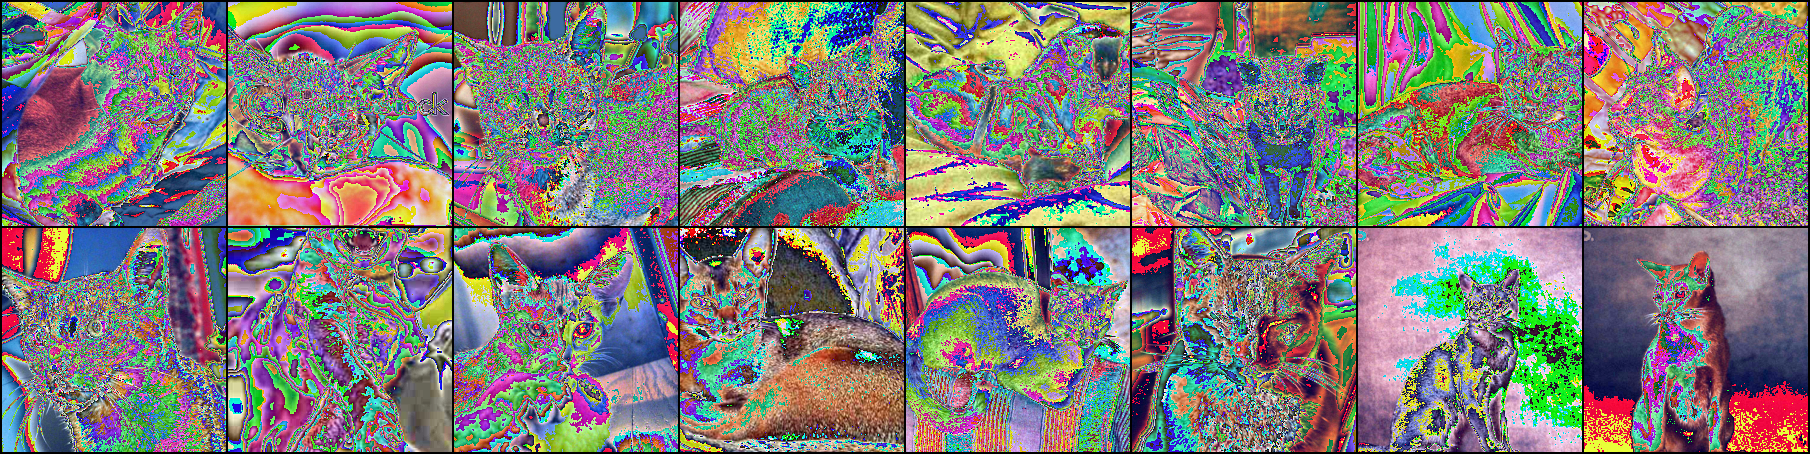

In [24]:
# train sample preview after clip preprocessing
T.ToPILImage()(grid2)

In [25]:
# Dataloaders

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

print("Train batches:", len(train_loader))
print("Test batches:",len(test_loader))

Train batches: 58
Test batches: 58


In [26]:
# Model class

class R50_encoder(torch.nn.Module):
    def __init__(self,weights, freeze_weights):
        super(R50_encoder, self).__init__()

        # Load the ResNet50 model
        self.resnet = torchvision.models.resnet34(weights=weights)
        
        # Freezing the weights of the encoder
        if freeze_weights:
            for param in self.resnet.parameters():
                param.requires_grad = False
                
        # Remove the last linear layer
        self.layers = torch.nn.Sequential(*list(self.resnet.children())[:-1])


    def forward(self, x):
        outputs = self.layers(x)
        return outputs

In [27]:
def get_features(encoder,dataloader, device):
    features_arr =[]
    labels_arr = []
    
    # switch to the evaluation mode
    encoder.eval()
    
    for images, labels in tqdm(dataloader):
            # load the images to GPU
            images = images.to(device)
            
            features = encoder(images)
            features = features.view(features.shape[0],-1).detach().cpu().numpy()
            
            features_arr.append(features)
            labels_arr.append(labels)
   
    # combine batches
    features_arr = np.concatenate(features_arr, axis=0)
    labels_arr = np.concatenate(labels_arr, axis=0)

    return features_arr, labels_arr

In [28]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

encoder = R50_encoder(weights = weights, freeze_weights=True)
encoder = encoder.to(torch.float32)
encoder = encoder.to(device)

In [29]:
# Get the features of the train and test images

x_train,y_train = get_features(encoder,train_loader, device)
x_test, y_test = get_features(encoder,test_loader, device)

100%|██████████| 58/58 [00:25<00:00,  2.28it/s]


In [34]:
# Search for the best k value by Cross Validation

grid = {'n_neighbors': [i for i in range(1,15)]}

knn_classifier = KNeighborsClassifier(metric='euclidean')

grid_search = GridSearchCV(knn_classifier, grid, cv=5, scoring='accuracy')
grid_search.fit(x_train, y_train)

k = grid_search.best_params_['n_neighbors']

print("Best K:", grid_search.best_params_)

Best K: {'n_neighbors': 9}


In [35]:
knn_classifier = KNeighborsClassifier(n_neighbors=k, metric='euclidean')
knn_classifier.fit(x_train, y_train)

preds = knn_classifier.predict(x_test)

accuracy = accuracy_score(y_test, preds, normalize=True)
print(f"Accuracy: {(100*accuracy):.3f}%")

Accuracy: 88.907%


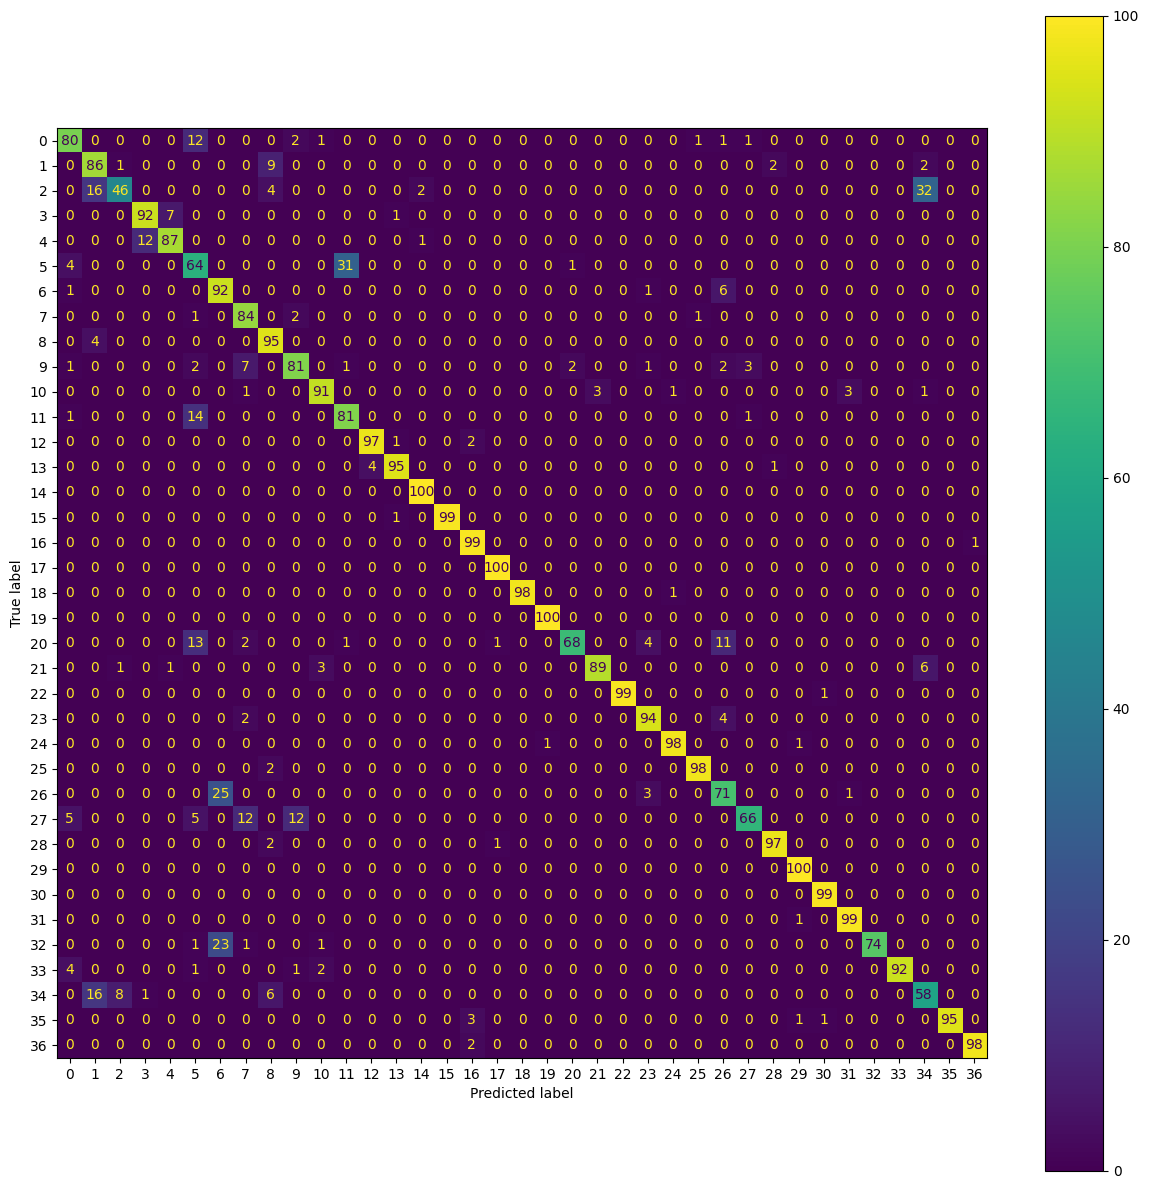

In [32]:
# Confusion Matrix

cm = confusion_matrix(y_test, preds, labels=knn_classifier.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=knn_classifier.classes_)

fig, ax = plt.subplots(figsize=(15,15))
disp.plot(ax=ax)
plt.show()